In [1]:
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import copy
from IPython import display
display.set_matplotlib_formats("svg")

C:\Users\Admin\AppData\Local\Temp\ipykernel_13772\1198610726.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats("svg")


In [2]:
data = pd.read_csv("../FFN/mnist_train_small.csv", header=None)

# extract labels (number ID's) and remove from data
labels = data.values[:, 0]  # Convert DataFrame to NumPy before slicing
data = data.values[:, 1:]

# normalize the data to a range of [0 1]
dataNorm = data/np.max(data)

In [3]:
# Step 1: convert to tensor
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()

# Step 2: use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size = .1)

# Step 3: convert into Pytorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Step 4: translate into dataloader objects
batchsize = 32
train_loader = DataLoader(train_data, batch_size = batchsize, shuffle = True, drop_last = True)
test_loader = DataLoader(test_data, batch_size = test_data.tensors[0].shape[0])

In [4]:
# creating a class for the model
def createTheMNISTNet():
    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            # input layer
            self.input = nn.Linear(784, 64)

            # hidden layer
            self.fc1 = nn.Linear(64, 32)
            self.fc2 = nn.Linear(32, 32)

            # output layer
            self.output = nn.Linear(32, 10)

        # forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            return self.output(x)

    # create the model instance
    net = mnistNet()

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr = .001) # Adam performs way too good for this model therefore we used SGD

    return net, lossfun, optimizer

In [10]:
 # train the model

def trainTheModel(net, lossfun, optimizer):

    # training parameter
    numepochs = 60
    
    trainAcc = []
    testAcc = []
    losses = torch.zeros(numepochs)

    # intialize weight change matrices
    weightChange = np.zeros((numepochs, 4)) # euclidean distance
    weightConds = np.zeros((numepochs, 4)) # condition numbers
    
    # train the model
    for epochi in range(numepochs):

        # store the weights for each layer
        preW = []
        for p in net.named_parameters():
            if "weight" in p[0]:
                preW.append(copy.deepcopy(p[1].data.numpy()))
        
        # loop over training data batches
        net.train()
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)
            
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute training accuracy for this batch
            matches = torch.argmax(yHat, axis = 1) == y # booleans (false/true); selects the class with the highest predicted probability for each input.
            # The == operator compares the predicted class to the actual class, returning a Boolean tensor (True for correct predictions, False for incorrect).
            matchesNumeric = matches.float() # convert to numbers (0/1)
            accuracyPct = 100*torch.mean(matchesNumeric) # avg and * by 100
            batchAcc.append(accuracyPct)
            
        # now that we've trained through the batches, get avg training accuracy
        trainAcc.append(np.mean(batchAcc))

        # get avg losses over the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        net.eval()
        X, y = next(iter(test_loader))  # extract X, y from test dataloader
        with torch.no_grad():
            yHat = net(X)

        # compute test accuracy
        testAcc.append(100 * torch.mean((torch.argmax(yHat, axis = 1) == y).float()))

        # finally, get the post-learning state of the weights
        for (i, p) in enumerate(net.named_parameters()):
            if "weight" in p[0]:
                # condition number
                weightConds[epochi, int(i/2)] = np.linalg.cond(p[1].data)
    
                # frobenius norm of the weight change from pre-learning
                weightChange[epochi, int(i/2)] = np.linalg.norm(preW[int(i/2)] - p[1].data.numpy(), ord = "fro")
        
    # function output
    return trainAcc, testAcc, losses, net, weightChange, weightConds, preW

In [11]:
# create a network
net, lossfun, optimizer = createTheMNISTNet()

# train the model
trainAcc, testAcc, losses, net, weightChange, weightConds, preW = trainTheModel(net, lossfun, optimizer)

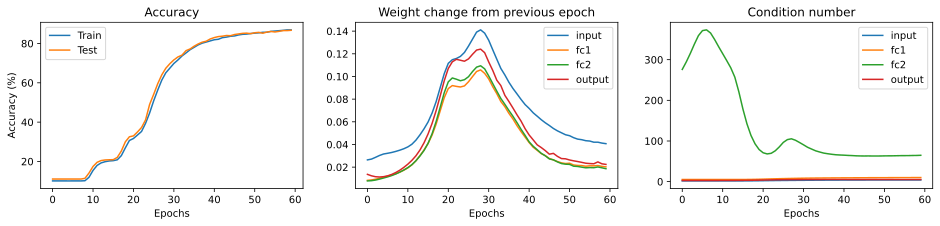

In [13]:
# get a list of layer names
layername = []
for (i,p) in enumerate(net.named_parameters()):
  if 'weight' in p[0]:
    layername.append(p[0][:-7])

# set up the plot
fig,ax = plt.subplots(1,3,figsize=(16,3))

# accuracy
ax[0].plot(trainAcc)
ax[0].plot(testAcc)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy (%)')
ax[0].set_title('Accuracy')
ax[0].legend(['Train','Test'])

# weight changes
ax[1].plot(weightChange)
ax[1].set_xlabel('Epochs')
ax[1].set_title('Weight change from previous epoch')
ax[1].legend(layername)

# weight condition numbers
ax[2].plot(weightConds)
ax[2].set_xlabel('Epochs')
ax[2].set_title('Condition number')
ax[2].legend(layername)
# ax[2].set_ylim([0,20])

plt.show()

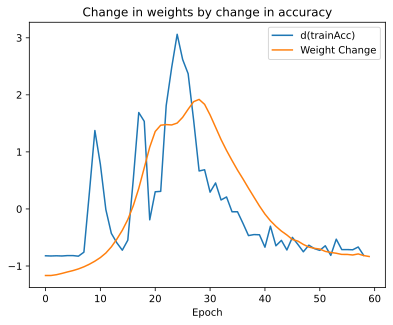

In [15]:
# final inspection: check the derivative of accuracy against the weight change
from scipy.stats import zscore # normalize for scaling offsets

plt.plot(zscore(np.diff(trainAcc)), label = "d(trainAcc)")
plt.plot(zscore(np.mean(weightChange, axis = 1)), label = "Weight Change")
plt.legend()
plt.title("Change in weights by change in accuracy")
plt.xlabel("Epoch")
plt.show()